In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from sklearn.feature_extraction.text import CountVectorizer
from tokenizer import tokenizer
from gensim.corpora import Dictionary
from gensim.corpora.bleicorpus import BleiCorpus

sns.set()

In [20]:
def cum_dist_plot(array, quantiles = [0.6, 0.8, 0.9, 0.95, 0.99], figsize=(16,9)):
    """
    cummulative distribution over series values
    """
    # cum dist
    serie = pd.Series(array)
    serie_sorted = serie.sort_values(ascending=False)
    indexs = range(1, len(serie_sorted)+1)
    cum_dist = []

    cum = 0
    for value in serie_sorted:
        cum += value
        cum_dist.append(cum)

    cum_dist = pd.Series(cum_dist)
    
    #quantiles
    q_indexs = [] 
    q_cum = [] 

    labels = [f"q{int(100*q)}" for q in quantiles] 
    for q in quantiles:
        cut = cum_dist.max()*q
        slice = cum_dist[cum_dist<cut]
        i, value = slice.index[-1], slice.values[-1]
        q_indexs.append(i)
        q_cum.append(value)

    #plot cum dis
    fig, ax = plt.subplots(figsize=figsize)        
    ax.plot(indexs, cum_dist)

    #plot quantiles
    ax.scatter(q_indexs, q_cum)
    for i, label in enumerate(labels):
        ax.annotate(label, (q_indexs[i], q_cum[i]))    
    return ax

        
def get_stats(array, quantiles = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95, 0.99]):
    """
    Return  statistis over the distribution of the serie
    """
    serie = pd.Series(array)
    stats = pd.DataFrame(serie.describe()).T
    stats = stats[["count", "mean", "std", "min"]]
    for q in quantiles:
        qq = serie.quantile(q)
        col = f"q{int(q*100)}"
        stats[col] = qq
    stats["max"] = serie.max()
    return stats

# 1. Loading Raw Data

In [4]:
# load environment variables
load_dotenv()

True

In [5]:
# load data
df = pd.read_pickle(os.getenv("TARGET_DATA"))

In [6]:
tf_vectorizer = CountVectorizer(analyzer='word', tokenizer=lambda text: text.split())
tf_vectorizer.fit(df["sin_relato"])
vocabulary1 = tf_vectorizer.get_feature_names()
corpus1 = [doc.split() for doc in df["sin_relato"]]

voc_size1 = len(vocabulary1)
corpus_size1 = sum([1 for doc in corpus1 if len(doc)>0])
tokens_size1 = sum([len(doc) for doc in corpus1])

print(f"corpus: {corpus_size1}")
print(f"vocabulary: {voc_size1}")
print(f"tokens: {tokens_size1}")

corpus: 49015
vocabulary: 79327
tokens: 2030980


In [8]:
tf_vectorizer = CountVectorizer(analyzer='word', tokenizer=lambda text: text.split())
tf_vectorizer.fit(df["sin_relato"])
vocabulary1 = tf_vectorizer.get_feature_names()
corpus1 = [doc.split() for doc in df["sin_relato"]]

voc_size1 = len(vocabulary1)
corpus_size1 = sum([1 for doc in corpus1 if len(doc)>0])
tokens_size1 = sum([len(doc) for doc in corpus1])

print(f"corpus: {corpus_size1}")
print(f"vocabulary: {voc_size1}")
print(f"tokens: {tokens_size1}")

corpus: 49015
vocabulary: 79327
tokens: 2030980


# 2. First processing step

To lowercase, elimination of symbols of punctuation, mails and tokens with numbers.

In [21]:
tf_vectorizer = CountVectorizer(analyzer='word', tokenizer=lambda text: tokenizer(text))
tf_vectorizer.fit(df["sin_relato"])
vocabulary2 = tf_vectorizer.get_feature_names()
frequency = tf_vectorizer.transform(df["sin_relato"]).toarray().sum(axis=0)

corpus2 = [tokenizer(doc) for doc in df["sin_relato"]]

voc_size2 = len(vocabulary2)
corpus_size2 = sum([1 for doc in corpus2 if len(doc)>0])
tokens_size2 = sum([len(doc) for doc in corpus2])

print(f"corpus: {corpus_size2 }")
print(f"vocabulary: {voc_size2}")
print(f"tokens: {tokens_size2}")

corpus: 49011
vocabulary: 46708
tokens: 1947235


In [22]:
get_stats(frequency, quantiles = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95, 0.99])

,count,mean,std,min,q10,q20,q25,q30,q40,q50,q60,q70,q75,q80,q90,q95,q99,max
0,46708.0,41.689689,956.464381,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,5.0,14.0,41.0,383.0,79877


Text(0, 0.5, 'Frecuencia acumulada')

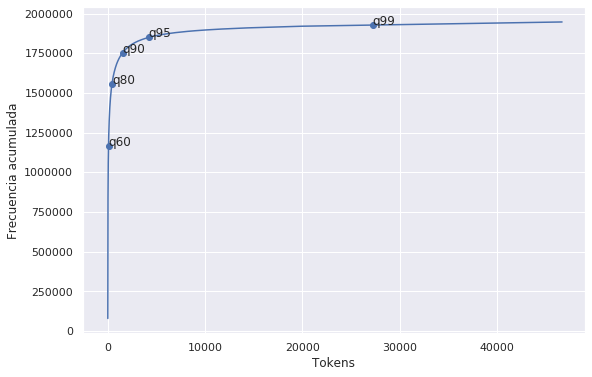

In [23]:
ax = cum_dist_plot(frequency, quantiles = [0.6, 0.8, 0.9, 0.95, 0.99], figsize=(9,6))
ax.set_xlabel("Tokens")
ax.set_ylabel("Frecuencia acumulada")

The 50% of tokens happens one time and the 80% have a frequency lower or equal to 5. The 95% of the cummulative distribution can be explain with 4199 tokens (9%). In conclusion, the distribution of tokens have a long tail.

# 3. Full processing

- stopwords elimination: nltk spanish stopwords + word from top 1000 more frequent from last output 
- lemmatization: spacy_spanish_lemmatizer
- remove tokens with occurrence in less than 5 documents in a corpus slice (1 year)

## Stopwords

In [24]:
# load stopwords
with open(os.getenv("STOPWORDS"), "r") as f:
    stopwords = [line.strip() for line in f]

In [25]:
stopwords = pd.Series(stopwords)

In [42]:
stopwords.sort_values().iloc[-203:-195]

571       roba
587     robada
464     robado
269      roban
705    robando
233      robar
396    robaron
204       robo
dtype: object

In [44]:
stopwords.sort_values().iloc[-40:-20]

235           va
592          van
246       varias
110           ve
564       vecino
540          veh
18       vehculo
140     vehiculo
470    vehiculos
595     vehiuclo
16      vehyculo
640     vehículo
71           veo
73           ver
723        verlo
186     vespucio
632          vez
657           vh
85           vhc
236          vhe
dtype: object

## Lemmatization + elimination of tokens with lower ocurrences
To continue the results of lematization and elimination of tokens with lower ocurrences.

In [15]:
corpus_path = f'{os.getenv("CORPUS")}{os.getenv("SLICE_TYPE")}/'
dict_files = sorted([file for file in os.listdir(corpus_path) if ".dict" in file])
corpus_files = sorted([file for file in os.listdir(corpus_path) if ".mm" in file and ".index" not in file and ".vocab" not in file])

In [18]:
slices = range(1, 7)
data = {}
for slice in slices:
    # load dictionary {word->id}
    dict_path = f"{corpus_path}{dict_files[slice-1]}"
    dictionary = Dictionary.load(dict_path)
    # load corpus
    corpus_file = f"{corpus_path}{corpus_files[slice-1]}"
    corpus = BleiCorpus(corpus_file)
    # save data in a dict
    data[slice] = {"dict": dictionary, "corpus": corpus}
    
vocabulary = set()
for slice in slices:
    vocabulary = vocabulary.union(data[slice]["dict"].token2id.keys())

In [182]:
corpus_size3 =  sum([len(data[slice]["corpus"]) for slice in slices])
vocab_size3 = len(vocabulary)
tokens_size3 = int(sum([freq for slice in slices for doc in data[slice]["corpus"] for (id, freq) in doc]))
print(f"corpus: {corpus_size3}")
print(f"vocabulary: {vocab_size3}")
print(f"tokens: {tokens_size3}")

corpus: 47993
vocabulary: 4106
tokens: 508987


In [274]:
frequency = {}
for slice in slices:
    id2token = {value: key for key, value in data[slice]["dict"].token2id.items()}
    for doc in data[slice]["corpus"]:
        for (id, freq) in doc:
            token = id2token[id]
            if token not in frequency.keys():
                frequency[token] = freq
            else:
                frequency[token] += freq
frequency = np.array(list(frequency.values()))

In [276]:
get_stats(frequency, quantiles = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95, 0.99])

,count,mean,std,min,q10,q20,q25,q30,q40,q50,q60,q70,q75,q80,q90,q95,q99,max
0,4106.0,123.961763,671.399449,5.0,5.0,7.0,8.0,11.0,16.0,25.0,37.0,57.0,72.0,90.0,168.0,383.75,1902.55,27822.0


Text(0, 0.5, 'Frecuencia acumulada')

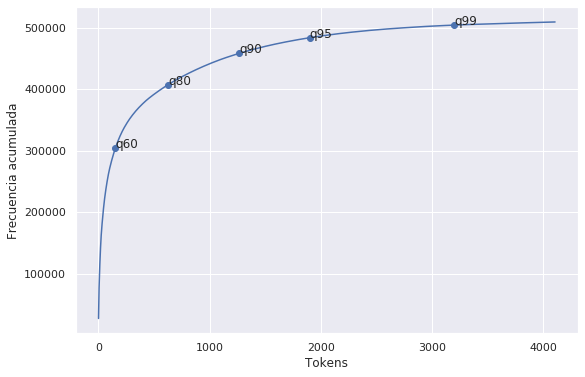

In [277]:
ax = cum_dist_plot(frequency, quantiles = [0.6, 0.8, 0.9, 0.95, 0.99], figsize=(9,6))
ax.set_xlabel("Tokens")
ax.set_ylabel("Frecuencia acumulada")

# 4. Innovation rate

How much change the vocabulary between adjacent epoch

In [278]:
innovation_data = []
for slice in slices[:-1]:
    vocabulary1 = set(data[slice]["dict"].token2id.keys())
    vocabulary2= set(data[slice+1]["dict"].token2id.keys())
    
    old_vocabulary = len(vocabulary1)
    new_vocabulary = len(vocabulary2)
    
    old_words = round(100*len(vocabulary1-vocabulary2)/old_vocabulary, 2)
    new_words = round(100*len(vocabulary2-vocabulary1)/old_vocabulary, 2)
    vocabulary_change = {"slice":slice+1, "old_vocabulary": old_vocabulary, "new_vocabulary": new_vocabulary, 
     "%old_words": old_words, "%new_words":new_words}
    innovation_data.append(vocabulary_change)


In [279]:
innovation_rate = pd.DataFrame(innovation_data)
innovation_rate

,slice,old_vocabulary,new_vocabulary,%old_words,%new_words
0,2,1919,1986,23.35,26.84
1,3,1986,2092,22.61,27.95
2,4,2092,2414,18.21,33.60
3,5,2414,2629,19.80,28.71
4,6,2629,2666,22.44,23.85
